In [2]:
!pip install basedosdados

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.2/135.2 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.0/106.0 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import os
import glob
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import basedosdados as bd

In [4]:
# Define directory
path = '/content/drive/MyDrive/ComprasPublicas_Brasil/'

# Define project id
project_id_bq = 'budget-execution-procurement'

In [ ]:
# Total of municipalities from our commitment data in relation with Siconfi data

"""
query = '''
WITH commitment AS (
  SELECT
    ano,
    sigla_uf,
    COUNT (DISTINCT id_municipio) AS municipalities_tce,
  FROM basedosdados.world_wb_mides.empenho
  GROUP BY 1,2
),
  siconfi AS (
  SELECT
  ano,
  sigla_uf,
  COUNT (DISTINCT id_municipio) AS municipalities_siconfi
  FROM `basedosdados.br_me_siconfi.municipio_despesas_orcamentarias`
  WHERE sigla_uf IN ('CE', 'MG', 'PB', 'PE', 'PR', 'RS', 'SP') AND ano >= 2008 AND estagio_bd = 'Despesas Empenhadas' AND conta_bd = 'Despesas Orçamentárias'
  GROUP BY 1,2
)

SELECT
  s.ano AS year_siconfi,
  e.ano AS year_tce,
  s.sigla_uf AS state_siconfi,
  e.sigla_uf AS state_tce,
  municipalities_tce,
  municipalities_siconfi
FROM commitment e
FULL OUTER JOIN siconfi s ON e.ano=s.ano AND e.sigla_uf=s.sigla_uf
'''

commitment_siconfi = bd.read_sql(query, billing_project_id=project_id_bq)
"""

commitment_siconfi = pd.read_csv(os.path.join(path, 'output/temp/data_commitment_siconfi.csv'))

commitment_siconfi['year_tce'] = commitment_siconfi['year_tce'].replace(np.nan, 0).astype(int)
commitment_siconfi = commitment_siconfi.sort_values(by=['state_siconfi', 'state_tce', 'year_siconfi', 'year_tce'])

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(12,8))
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1a476f', '#c10534'])

commitment_siconfi.query('state_tce == "CE"').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax1, marker='.', legend=None)
commitment_siconfi.query('state_tce == "MG"').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax2, marker='.', legend=None)
commitment_siconfi.query('state_tce == "PB" & year_tce > 2008').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax3, marker='.', legend=None)
commitment_siconfi.query('state_tce == "PR"').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax4, marker='.', legend=None)
commitment_siconfi.query('state_tce == "RS" & year_tce > 2009').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax5, marker='.', legend=None)
commitment_siconfi.query('state_tce == "SP"').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax6, marker='.', legend=None)

ax1.set_title("CE")
ax1.set_ylabel('Municipalities')
ax1.set_xlabel(None)
ax1.set_xticks(np.arange(2009,2022,2))
ax2.set_title("MG")
ax2.set_xlabel(None)
ax3.set_title("PB")
ax3.set_yticks([210,213,216,219,221,223])
ax3.set_ylabel('Municipalities')
ax3.set_xlabel(None)
ax3.set_xticks(np.arange(2009,2021,2))
ax4.set_title("PR")
ax4.set_xlabel(None)
ax5.set_title("RS")
ax5.set_ylabel('Municipalities')
ax5.set_xlabel('Year')
ax6.set_title("SP")
ax6.set_xlabel('Year')


plt.tight_layout()
plt.legend(['Municipalities from our data', 'Municipalities from Siconfi'], bbox_to_anchor =(-0.1,-0.5), loc='lower center', ncol=2)
plt.savefig(path + 'output/graficos/total_municipalities_commitment.pdf', bbox_inches='tight')
plt.show()

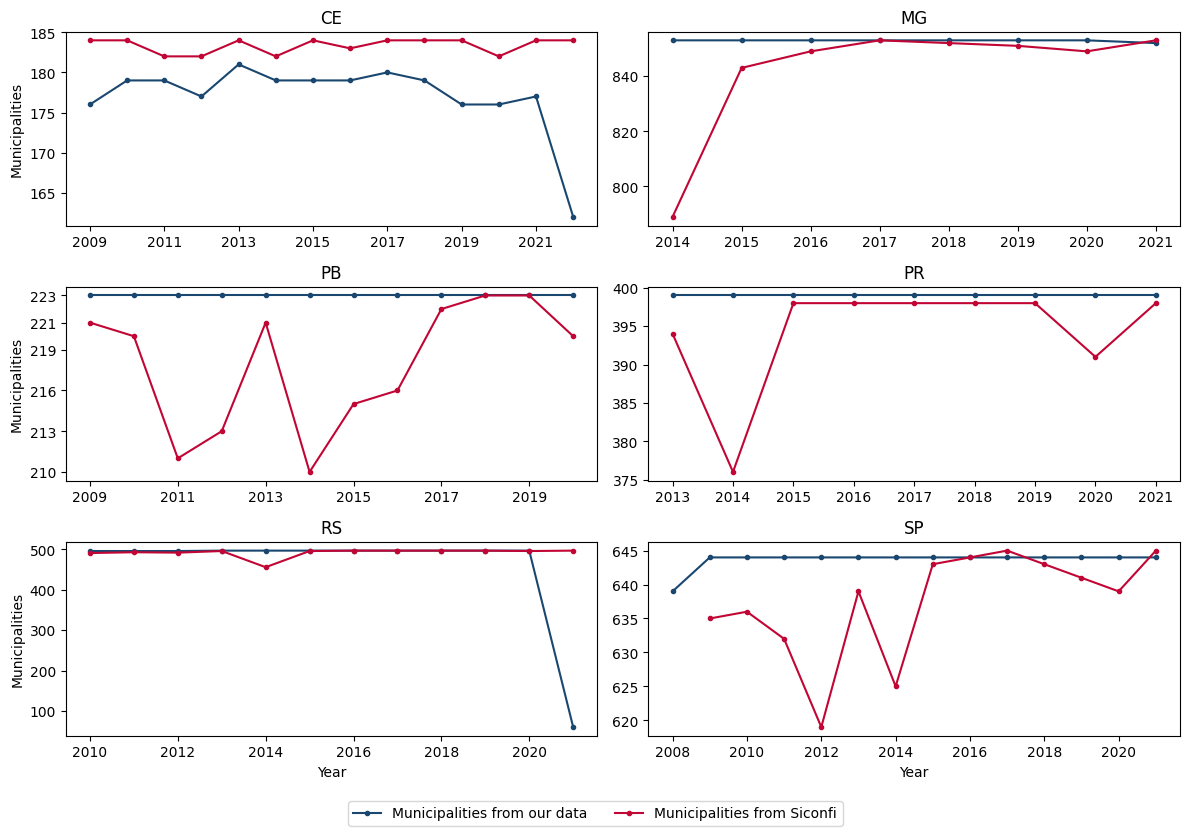

In [7]:
# Total of municipalities from our verification data in relation with Siconfi data

"""
query = '''
WITH verification AS (
  SELECT
    ano,
    sigla_uf,
    COUNT (DISTINCT id_municipio) AS municipalities_tce,
  FROM basedosdados.world_wb_mides.liquidacao
  GROUP BY 1,2
),
  siconfi AS (
  SELECT
  ano,
  sigla_uf,
  COUNT (DISTINCT id_municipio) AS municipalities_siconfi
  FROM `basedosdados.br_me_siconfi.municipio_despesas_orcamentarias`
  WHERE sigla_uf IN ('CE', 'MG', 'PB', 'PE', 'PR', 'RS', 'SP') AND ano >= 2008 AND estagio_bd = 'Despesas Liquidadas' AND conta_bd = 'Despesas Orçamentárias'
  GROUP BY 1,2
)

SELECT
  s.ano AS year_siconfi,
  e.ano AS year_tce,
  s.sigla_uf AS state_siconfi,
  e.sigla_uf AS state_tce,
  municipalities_tce,
  municipalities_siconfi
FROM verification e
FULL OUTER JOIN siconfi s ON e.ano=s.ano AND e.sigla_uf=s.sigla_uf
'''

verification_siconfi = bd.read_sql(query, billing_project_id=project_id_bq)
"""
verification_siconfi = pd.read_csv(os.path.join(path, 'output/temp/data_verification_siconfi.csv'))

verification_siconfi['year_tce'] = verification_siconfi['year_tce'].replace(np.nan, 0).astype(int)
verification_siconfi['year_siconfi'] = np.where(verification_siconfi.year_tce == 2008, 2008, verification_siconfi.year_siconfi)
verification_siconfi['state_siconfi'] = np.where(verification_siconfi.year_tce == 2008, 'SP', verification_siconfi.state_siconfi)
verification_siconfi = verification_siconfi.sort_values(by=['state_siconfi', 'state_tce', 'year_siconfi', 'year_tce'])

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(12,8))
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1a476f', '#c10534'])

verification_siconfi.query('state_tce == "CE"').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax1, marker='.', legend=None)
verification_siconfi.query('state_tce == "MG"').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax2, marker='.', legend=None)
verification_siconfi.query('state_tce == "PB" & year_tce > 2008').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax3, marker='.', legend=None)
verification_siconfi.query('state_tce == "PR"').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax4, marker='.', legend=None)
verification_siconfi.query('state_tce == "RS" & year_tce > 2009').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax5, marker='.', legend=None)
verification_siconfi.query('state_tce == "SP"').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax6, marker='.', legend=None)

ax1.set_title("CE")
ax1.set_ylabel('Municipalities')
ax1.set_xlabel(None)
ax1.set_xticks(np.arange(2009,2022,2))
ax2.set_title("MG")
ax2.set_xlabel(None)
ax3.set_title("PB")
ax3.set_yticks([210,213,216,219,221,223])
ax3.set_ylabel('Municipalities')
ax3.set_xlabel(None)
ax3.set_xticks(np.arange(2009,2021,2))
ax4.set_title("PR")
ax4.set_xlabel(None)
ax5.set_title("RS")
ax5.set_ylabel('Municipalities')
ax5.set_xlabel('Year')
ax6.set_title("SP")
ax6.set_xlabel('Year')


plt.tight_layout()
plt.legend(['Municipalities from our data', 'Municipalities from Siconfi'], bbox_to_anchor =(-0.1,-0.5), loc='lower center', ncol=2)
plt.savefig(path + 'output/graficos/total_municipalities_verification.pdf', bbox_inches='tight')
plt.show()

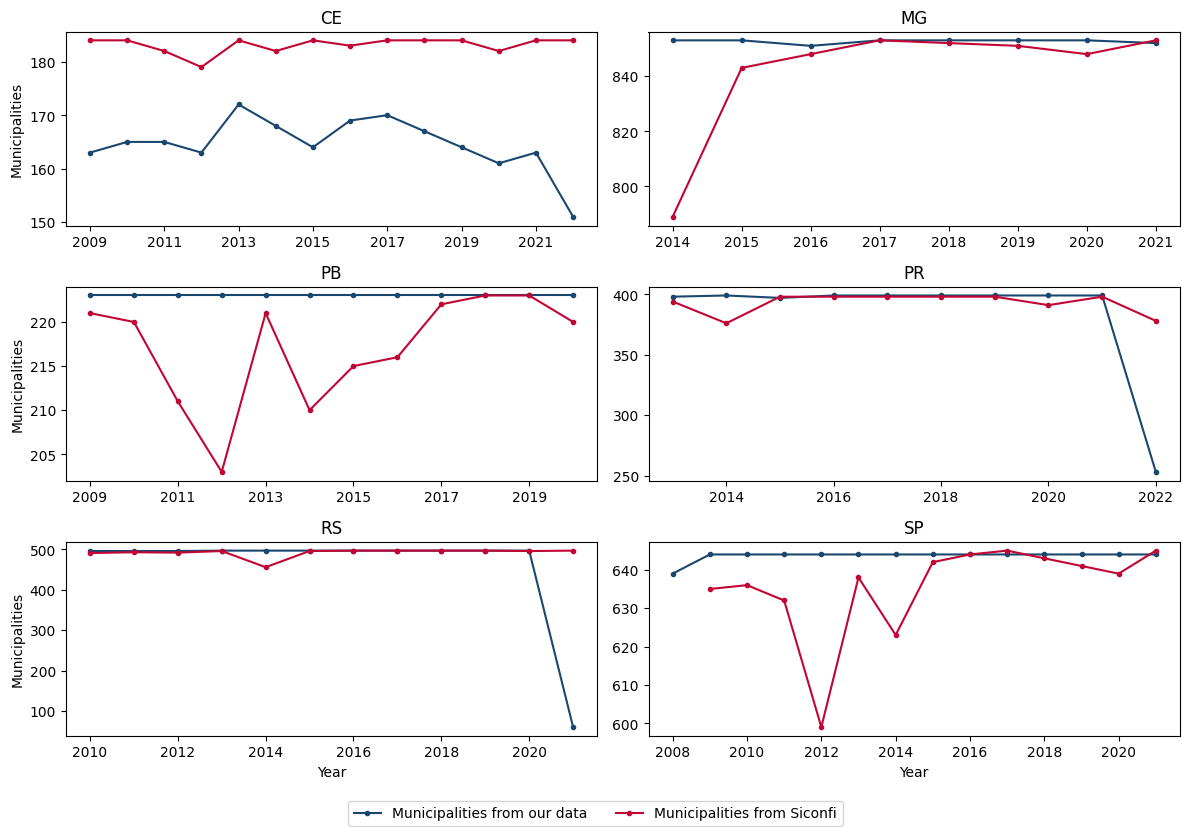

In [14]:
# Total of municipalities from our commitment data in relation with Siconfi data

"""
query = '''
WITH payment AS (
  SELECT
    ano,
    sigla_uf,
    COUNT (DISTINCT id_municipio) AS municipalities_tce,
  FROM basedosdados.world_wb_mides.pagamento
  GROUP BY 1,2
),
  siconfi AS (
  SELECT
  ano,
  sigla_uf,
  COUNT (DISTINCT id_municipio) AS municipalities_siconfi
  FROM `basedosdados.br_me_siconfi.municipio_despesas_orcamentarias`
  WHERE sigla_uf IN ('CE', 'MG', 'PB', 'PE', 'PR', 'RS', 'SP') AND ano >= 2008 AND estagio_bd = 'Despesas Pagas' AND conta_bd = 'Despesas Orçamentárias'
  GROUP BY 1,2
)

SELECT
  s.ano AS year_siconfi,
  e.ano AS year_tce,
  s.sigla_uf AS state_siconfi,
  e.sigla_uf AS state_tce,
  municipalities_tce,
  municipalities_siconfi
FROM payment e
FULL OUTER JOIN siconfi s ON e.ano=s.ano AND e.sigla_uf=s.sigla_uf
'''

payment_siconfi = bd.read_sql(query, billing_project_id=project_id_bq)
"""
payment_siconfi = pd.read_csv(os.path.join(path, 'output/temp/data_payment_siconfi.csv'))

payment_siconfi['year_tce'] = payment_siconfi['year_tce'].replace(np.nan, 0).astype(int)
payment_siconfi['year_siconfi'] = payment_siconfi['year_siconfi'].replace(np.nan, 0).astype(int)
payment_siconfi['year_siconfi'] = np.where(payment_siconfi.year_tce == 2008, 2008, payment_siconfi.year_siconfi)
payment_siconfi['state_siconfi'] = np.where(payment_siconfi.year_tce == 2008, 'SP', payment_siconfi.state_siconfi)
payment_siconfi = payment_siconfi.sort_values(by=['state_siconfi', 'state_tce', 'year_siconfi', 'year_tce'])

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(12,8))
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1a476f', '#c10534'])

payment_siconfi.query('state_tce == "CE"').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax1, marker='.', legend=None)
payment_siconfi.query('state_tce == "MG"').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax2, marker='.', legend=None)
payment_siconfi.query('state_tce == "PB" & year_tce > 2008').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax3, marker='.', legend=None)
payment_siconfi.query('state_tce == "PR"').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax4, marker='.', legend=None)
payment_siconfi.query('state_tce == "RS" & year_tce > 2009').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax5, marker='.', legend=None)
payment_siconfi.query('state_tce == "SP"').plot(x="year_tce", y=["municipalities_tce", "municipalities_siconfi"], kind="line", ax=ax6, marker='.', legend=None)

ax1.set_title("CE")
ax1.set_ylabel('Municipalities')
ax1.set_xlabel(None)
ax1.set_xticks(np.arange(2009,2022,2))
ax2.set_title("MG")
ax2.set_xlabel(None)
ax3.set_title("PB")
ax3.set_ylabel('Municipalities')
ax3.set_xlabel(None)
ax3.set_xticks(np.arange(2009,2021,2))
ax4.set_title("PR")
ax4.set_xlabel(None)
ax5.set_title("RS")
ax5.set_ylabel('Municipalities')
ax5.set_xlabel('Year')
ax6.set_title("SP")
ax6.set_xlabel('Year')


plt.tight_layout()
plt.legend(['Municipalities from our data', 'Municipalities from Siconfi'], bbox_to_anchor =(-0.1,-0.5), loc='lower center', ncol=2)
plt.savefig(path + 'output/graficos/total_municipalities_payment.pdf', bbox_inches='tight')
plt.show()

In [8]:
verification_siconfi.query('state_tce == "PB"')

,year_siconfi,year_tce,state_siconfi,state_tce,municipalities_tce,municipalities_siconfi
15,2009.00,2009,PB,PB,223.00,221.00
31,2010.00,2010,PB,PB,223.00,220.00
25,2011.00,2011,PB,PB,223.00,211.00
77,2012.00,2012,PB,PB,223.00,213.00
29,2013.00,2013,PB,PB,223.00,221.00
18,2014.00,2014,PB,PB,223.00,210.00
59,2015.00,2015,PB,PB,223.00,215.00
90,2016.00,2016,PB,PB,223.00,216.00
23,2017.00,2017,PB,PB,223.00,222.00
51,2018.00,2018,PB,PB,223.00,223.00


In [9]:
payment_siconfi.query('state_tce == "PB"')

,year_siconfi,year_tce,state_siconfi,state_tce,municipalities_tce,municipalities_siconfi
86,2009,2009,PB,PB,223.00,221.00
99,2010,2010,PB,PB,223.00,220.00
36,2011,2011,PB,PB,223.00,211.00
93,2012,2012,PB,PB,223.00,203.00
100,2013,2013,PB,PB,223.00,221.00
8,2014,2014,PB,PB,223.00,210.00
119,2015,2015,PB,PB,223.00,215.00
51,2016,2016,PB,PB,223.00,216.00
23,2017,2017,PB,PB,223.00,222.00
110,2018,2018,PB,PB,223.00,223.00
